In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.getenv("GEMINI_API_KEY")

In [2]:
model="gemini-2.0-flash"
emb_model = "models/gemini-embedding-001"
model_name = "sentence-transformers/all-mpnet-base-v2"

In [25]:
import streamlit as st
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict, Tuple
from langchain_core.documents import Document
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain_core.prompts import PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
import os
from dotenv import load_dotenv

model_name = "medgemma-4b-it"

emb_model_name = "sentence-transformers/all-mpnet-base-v2"

llm = ChatOpenAI(
    base_url="http://localhost:1234/v1",
    model=model_name,
    api_key="lm-studio"
)

embeddings = HuggingFaceEmbeddings(model_name=emb_model_name)

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings

llm = ChatGoogleGenerativeAI(model=model)
# embeddings = GoogleGenerativeAIEmbeddings(model=emb_model)
embeddings = HuggingFaceEmbeddings(model_name=model_name)

In [5]:
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA

from langchain.document_loaders import TextLoader
loader = TextLoader(file_path="./car_inventory.txt")
docs = loader.load()

In [6]:
from langchain.text_splitter import CharacterTextSplitter
splitter = CharacterTextSplitter(
    separator="\n\n",
    chunk_size=700,     # Optional: max token/char size
    chunk_overlap=0
)

# Step 3: Split the loaded documents
split_docs = splitter.split_documents(docs)

In [7]:
len(split_docs)

500

In [40]:
split_docs[0]

Document(metadata={'source': './car_inventory.txt'}, page_content='2023 Tesla Model 3 (Performance, used) is available at BMW of Fremont in New Jasonhaven, PR. It is a Coupe with Automatic transmission, runs on Hybrid, and has 32,594 miles. The MSRP is $34,371 with a discount of $500, bringing the final price to $33,871.\nFeatures include: 4WD/AWD, Auto Dimming Mirror, Remote Start.\nCurrent offers: GM Educator Offer ($-500); Purchase Allowance ($-500).\nVIN: N6R0D6K9D7M3W0V6U7M0L1A2G1W5K8 | Stock Number: BMW001.\nImage: https://example.com/images/tesla_model3.jpg')

In [41]:
vectorstore = FAISS.from_documents(split_docs, embeddings)

In [42]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 5}),
    return_source_documents=True
)
qa_chain

RetrievalQA(verbose=False, combine_documents_chain=StuffDocumentsChain(verbose=False, llm_chain=LLMChain(verbose=False, prompt=ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context'], input_types={}, partial_variables={}, template="Use the following pieces of context to answer the user's question. \nIf you don't know the answer, just say that you don't know, don't try to make up an answer.\n----------------\n{context}"), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='{question}'), additional_kwargs={})]), llm=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000001C8B95C4350>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001C8B9A010D0>, root_client=<openai.OpenAI object at

In [43]:
user_input = "I want a car under $25000"
response = qa_chain.invoke(user_input)
print(response)

{'query': 'I want a car under $25000', 'result': 'Based on the provided information, here are the Acura Integra models available at Tesla San Jose that cost less than $25,000 (before any offers):\n\n*   **2023 Acura Integra (Base, used)**: $45,753 (after discount)\n*   **2025 Acura Integra (A-Spec Tech Package, used)**: $41,200 (after discount)\n*   **2023 Acura Integra (Base, new)**: $27,148 (after discount)\n\nTherefore, the 2023 Acura Integra (Base, used), 2025 Acura Integra (A-Spec Tech Package, used), and 2023 Acura Integra (Base, new) are all available under $25,000.\n', 'source_documents': [Document(id='a95c620b-eb33-40dc-8911-d2bb3b48ff8d', metadata={'source': './car_inventory.txt'}, page_content='2023 Acura Integra (Base, used) is available at Tesla San Jose in Reedchester, HI. It is a Truck with Dual-Clutch transmission, runs on Diesel, and has 14,995 miles. The MSRP is $47,753 with a discount of $2,000, bringing the final price to $45,753.\nFeatures include: Keyless Entry, P

In [44]:
print(response['result'])

Based on the provided information, here are the Acura Integra models available at Tesla San Jose that cost less than $25,000 (before any offers):

*   **2023 Acura Integra (Base, used)**: $45,753 (after discount)
*   **2025 Acura Integra (A-Spec Tech Package, used)**: $41,200 (after discount)
*   **2023 Acura Integra (Base, new)**: $27,148 (after discount)

Therefore, the 2023 Acura Integra (Base, used), 2025 Acura Integra (A-Spec Tech Package, used), and 2023 Acura Integra (Base, new) are all available under $25,000.



In [ ]:
from langchain_core.prompts import PromptTemplate

prompt_template = """
You are an expert AI car-buying assistant.

Below is a list of vehicle listings:
{context}

User question: {question}

Guidelines:
1. ONLY use information present in the context. Do not fabricate or guess.
2. If user asks about prices, calculate final price = msrp - discount (in USD).
3. If no vehicle matches, say: "Sorry, I couldn’t find any vehicles matching your criteria."
4. If vehicles match, show up to 2 suggestions with: make, model, year, final price, discount, dealer.
5. Be concise, friendly, and factual.

Answer:
"""

prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=prompt_template
)

messages = prompt.invoke({"question": user_input, "context": response['result']})
messages

StringPromptValue(text='\nYou are an expert AI car-buying assistant.\n\nYou will receive a knowledge base of vehicle listings in JSON format under Here are the cars listed under $25000:\n\n2024 Tesla Model 3 (Standard, used) is available at Ford Sunnyvale in Jonhaven, AR. It is a Sedan with Manual transmission, runs on Gasoline, and has 3,519 miles. The MSRP is $29,281 with a discount of $5,000, bringing the final price to $24,281.\nFeatures include: Keyless Entry, Adaptive Cruise Control, Cooled Seats.\nCurrent offers: Spartan Recovery Lync ($+999); GM Educator Offer ($-500); Purchase Allowance ($-500).\nVIN: Z7U7Y1W1W3R2R0Y8K0R6T9W7A2G1E2 | Stock Number: FORD400\nImage: https://example.com/images/tesla_model3.jpg\n\n2024 Tesla Model 3 (Standard, new) is available at Ford Sunnyvale in Lake Jonathan, PA. It is a Sedan with CVT transmission, runs on Diesel, and has 10 miles. The MSRP is $28,425 with a discount of $1,000, bringing the final price to $27,425.\nFeatures include: Power Tail

In [46]:
output = llm.invoke(messages)
output

AIMessage(content='Here are two cars under $25000 that you might like:\n\n1.  **2023 Ford Mustang (Dark Horse, certified)**: This Hatchback is available at Ford Sunnyvale in West Joshuaton, VA. It has 40,144 miles, runs on Gasoline, and has a final price of $23,493 after a $5,000 discount.\n2.  **2025 Tesla Model 3 (Performance, new)**: This Truck is available at Concord Acura in Stewartberg, SC. It has 10 miles, runs on Hybrid, and has a final price of $23,104 after a $2,000 discount.\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--0c85c078-864f-4bdc-97b2-e28605fc0268-0', usage_metadata={'input_tokens': 1178, 'output_tokens': 156, 'total_tokens': 1334, 'input_token_details': {'cache_read': 0}})

In [48]:
print(output.content)

Here are two cars under $25000 that you might like:

1.  **2023 Ford Mustang (Dark Horse, certified)**: This Hatchback is available at Ford Sunnyvale in West Joshuaton, VA. It has 40,144 miles, runs on Gasoline, and has a final price of $23,493 after a $5,000 discount.
2.  **2025 Tesla Model 3 (Performance, new)**: This Truck is available at Concord Acura in Stewartberg, SC. It has 10 miles, runs on Hybrid, and has a final price of $23,104 after a $2,000 discount.



In [4]:
from langchain.memory import (
    ChatMessageHistory,
    ConversationBufferMemory,

)
from langchain.chains import ConversationalRetrievalChain, LLMChain
from langchain.chains.conversational_retrieval.prompts import QA_PROMPT

In [ ]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 2})
message_history = ChatMessageHistory()
chat_memory = ConversationBufferMemory(
    memory_key="chat_history",
    output_key="answer",
    chat_memory=message_history,
    return_messages=True
)


# Using Langgraph

In [1]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict, Tuple
from langchain_core.documents import Document

In [10]:
from langchain_core.prompts import PromptTemplate

prompt_template = """
You are an expert AI car-buying assistant.

Below is the prior conversation history between you and the user:
{chat_history}

Below is a list of vehicle listings:  
{context}

User question: {question}

Guidelines:
1. ONLY use information present in the context. Do not fabricate or guess.
2. If user asks about prices, calculate final price = msrp - discount (in USD).
3. If no vehicle matches, say: "Sorry, I couldn’t find any vehicles matching your criteria."
4. If vehicles match, show up to 2 suggestions with: make, model, year, final price, discount, dealer.
5. Be concise, friendly, and factual.

Now based on the context and question, provide the best response:
"""

prompt = PromptTemplate(
    input_variables=["context", "question", "chat_history"],
    template=prompt_template
)


In [ ]:
# from langchain.retrievers import BM25Retriever, EnsembleRetriever
# dense_retriever = vectorstore.as_retriever()

# # === Step 3: Build BM25 Sparse Retriever ===
# sparse_retriever = BM25Retriever.from_documents(docs)
# sparse_retriever.k = 5  # top K matches

# # === Step 4: Hybrid Retriever ===
# hybrid_retriever = EnsembleRetriever(
#     retrievers=[dense_retriever, sparse_retriever],
#     weights=[0.6, 0.4]  # Tune weights as needed
# )

In [24]:

# memory = ConversationBufferMemory(return_messages=True)

# qa_chain = ConversationalRetrievalChain.from_llm(
#     llm, retriever=vectorstore.as_retriever(), memory=memory
# )
# result = qa_chain.invoke({"question": user_input, "chat_history": []})
# print({
#     "answer": result["answer"],
#     "context": result["source_documents"],
#     "chat_history": memory.chat_memory.messages  # OR sync to state if needed
# })

In [2]:
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str
    chat_history: List[Tuple[str, str]]



def retrieve(state: State):
    # retrived_docs = vectorstore.similarity_search(state['question'], search_kwargs={"k": 5})
    # retrived_docs = hybrid_retriever.get_relevant_documents(state['question'])
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        retriever=vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 5}),
        return_source_documents=True
    )
    response = qa_chain.invoke(state['question'])
    return {"context": response['result']}

def generate(state: State):
    # docs_content = "\n\n".join(doc.page_content for doc in state['context'])
    history_str = '\n'.join([f"User: {q}\nAssistant: {a}" for q, a in state.get("chat_history", [])])
    messages = prompt.invoke(
        {
            "question": state["question"],
            "context": state['context'],
            "chat_history": history_str
        }
    )
    response = llm.invoke(messages)

    chat_history = state.get("chat_history", [])
    chat_history.append((state["question"], response.content))
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

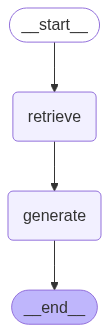

In [3]:
graph

In [16]:
user_input = "I want a car under $25K"
response = graph.invoke({"question": user_input})
print(response['answer'])

Here are a couple of cars under $25K that you might like:

*   2024 Tesla Model 3 (Standard, certified) is available at Ford Sunnyvale and costs $24,281.
*   2024 Chevrolet Tahoe (LT, certified) is available at Bay Area Honda and costs $22,721.



In [21]:
response

{'question': 'I want a car under $25K',
 'context': 'Here are the cars listed under $25K:\n\n2025 Ford Mustang (Dark Horse, certified) is available at Tesla San Jose in Gregorymouth, CT. It is a Truck with Manual transmission, runs on Hybrid, and has 3,832 miles. The final price is $25,180.\n\n2024 Tesla Model 3 (Standard, certified) is available at Ford Sunnyvale in Jonhaven, AR. It is a Sedan with Manual transmission, runs on Gasoline, and has 3,519 miles. The final price is $24,281.\n\n2023 Acura Integra (Type S, new) is available at Tesla San Jose in Michaelview, PR. It is a Sedan with Dual-Clutch transmission, runs on Electric, and has 10 miles. The final price is $25,255.\n\n2024 Chevrolet Tahoe (LT, certified) is available at Bay Area Honda in Joestad, ID. It is a Coupe with Automatic transmission, runs on Hybrid, and has 42,112 miles. The final price is $22,721.\n\n2025 Tesla Model 3 (Performance, new) is available at Concord Acura in Stewartberg, SC. It is a Truck with Automat

In [23]:
print(response['context'])

Here are the cars listed under $25K:

2025 Ford Mustang (Dark Horse, certified) is available at Tesla San Jose in Gregorymouth, CT. It is a Truck with Manual transmission, runs on Hybrid, and has 3,832 miles. The final price is $25,180.

2024 Tesla Model 3 (Standard, certified) is available at Ford Sunnyvale in Jonhaven, AR. It is a Sedan with Manual transmission, runs on Gasoline, and has 3,519 miles. The final price is $24,281.

2023 Acura Integra (Type S, new) is available at Tesla San Jose in Michaelview, PR. It is a Sedan with Dual-Clutch transmission, runs on Electric, and has 10 miles. The final price is $25,255.

2024 Chevrolet Tahoe (LT, certified) is available at Bay Area Honda in Joestad, ID. It is a Coupe with Automatic transmission, runs on Hybrid, and has 42,112 miles. The final price is $22,721.

2025 Tesla Model 3 (Performance, new) is available at Concord Acura in Stewartberg, SC. It is a Truck with Automatic transmission, runs on Hybrid, and has 10 miles. The final pr